<a href="https://colab.research.google.com/github/bayesbreeze/Rare-Events/blob/main/demos/demo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/bayesbreeze/Rare-Events.git

In [ ]:
!cd Rare-Events/demos

# 1D example

In [1]:
import torch
import numpy as np
from torch.distributions.normal import Normal
import torch.optim as optim
import torch.nn as nn
from nde.flows import realnvp
import tqdm
import matplotlib.pyplot as plt
from nde.flows import autoregressive as ar

centre = 0.0
level = 3
xlimits = [3, 20]
ylimits = [0, 1]

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device("cuda:0")
print("==run on=> ", device)

myNorm = Normal(torch.tensor([centre]), torch.tensor([1.0]))
def logf(x):
    return myNorm.log_prob(x[:,0])  + torch.log(x[:,0]>level)\
             + torch.log(x[:,1]>0) + torch.log(x[:,1]<1)

def survey_sample(n, centre, rho = 1):
    x = np.random.randn(n) * rho  + centre
    y = np.random.uniform(size=n, low =0, high=1)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1)).to(device)

def filterInputs(inputs):
    return inputs[((inputs[:,0]>xlimits[0]) * (inputs[:,0]<xlimits[1]))
                  * ((inputs[:,1]>ylimits[0]) * (inputs[:,1]<ylimits[1]))]

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

def plotHistory(history, level=10):
    history = np.array(history)
    idx =  np.where(history > level)[0][-1]
    history =  history[idx+1:]
    plt.plot(history)
    plt.show()

==run on=>  cpu


In [2]:
flow = realnvp.SimpleRealNVP(
    features=2,
    hidden_features=20,
    num_layers=8,
    num_blocks_per_layer=2,
)

# flow = ar.MaskedAutoregressiveFlow(
#             features=2,
#             hidden_features=20,
#             num_layers=8,
#             num_blocks_per_layer=2,
#         )

optimizer_servy = optim.Adam(flow.parameters(), lr=1e-2)
history = []
for epoch in range(100): #tqdm.notebook.tqdm(, desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(1000, 3, 5)
        inputs  = filterInputs(inputs)
        # print(inputs.shape)
    log_prob = flow.log_prob(inputs)
    optimizer_servy.zero_grad()
    loss = calLoss(inputs, log_prob)
    loss.backward()
    if loss == torch.nan:
        break
    optimizer_servy.step()
    history.append(loss.item())

print("===>", inputs[:,0].mean(), loss.item())
optimizer_refine = optim.Adam(flow.parameters(), lr=5e-4)
for epoch in range(1000): #tqdm.notebook.tqdm(, desc='Refine', leave=False):
    # print(epoch)
    with torch.no_grad():
        inputs = flow.sample(1000).detach()
        inputs  = filterInputs(inputs)

        if(epoch % 500 == 499):
            print(inputs[:,0].mean(), loss.item())
    log_prob = flow.log_prob(inputs)
    optimizer_refine.zero_grad()
    loss = calLoss(inputs, log_prob)
    if loss == torch.nan:
        break
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())


===> tensor(6.9556) 0.0036003387067466974
tensor(4.6825) 0.007543741725385189
tensor(4.7935) 0.006735433824360371


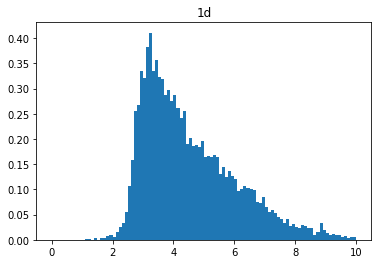

real: 0.0013499000,
mean: 0.0013524088,
 std: 0.0000397770, 
accuracy: 99.814%


In [3]:
def calIntegral(needprint=False):
    with torch.no_grad():
        x, loggx = flow.sample_and_log_prob(10000)
        s0, s1 = x[:,0], x[:,1]

        intgral = torch.exp(logf(x) - loggx).mean()

        if(needprint):
            plt.title("2d")
            # plt.subplot(122)
            plt.hist((s0).detach().numpy(), bins=100,  range=(0,  10), density=True) #, range=(0,  200)
            plt.title('1d')
            plt.show()
        return intgral

v = [calIntegral(i==0) for i in range(100)]
real = 0.0013499
print("real: %.10f,\nmean: %.10f,\n std: %.10f, \naccuracy: %.3f%%" % (real, np.mean(v),
                                np.std(v), (1-np.abs(np.mean(v) - real)/real)*100))

# 2D example

In [4]:
import torch
import numpy as np
from torch.distributions.normal import Normal
import torch.optim as optim
from nde.flows import autoregressive as ar
import matplotlib.pyplot as plt

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device("cuda:0")
print("==run on=> ", device)

centre = 0.0
level = 10
xlimits = [0, 30]
ylimits = [0, 30]
myNorm = Normal(torch.tensor([centre]), torch.tensor([1.0]))
def logf(x):
    return myNorm.log_prob(x[:,0])  + torch.log(x[:,0]>level)\
             + torch.log(x[:,1]>0) + torch.log(x[:,1]<1)

def logf(x):
      return -x[:, 0] -x[:, 1] + torch.log(x[:,0] + x[:,1] > level) \
             + torch.log(x[:,0]>0) + torch.log(x[:,1]>0)

def survey_sample(n, centre, rho = 1):
    x = np.random.uniform(size=n, low =0, high=level*1.5)
    y = np.random.uniform(size=n, low =0, high=level*1.5)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

def filterInputs(inputs):
    return inputs[((inputs[:,0]>xlimits[0]) * (inputs[:,0]<xlimits[1]))
                  * ((inputs[:,1]>ylimits[0]) * (inputs[:,1]<ylimits[1]))]

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

def plotHistory(history, level=10):
    history = np.array(history)
    # tmp  = np.where(history > level)
    idx =  0
    history =  history[idx+1:]
    plt.plot(history)
    plt.show()


==run on=>  cpu


In [5]:
# flow = realnvp.SimpleRealNVP(
#     features=2,
#     hidden_features=20,
#     num_layers=8,
#     num_blocks_per_layer=2,
# )
#
flow = ar.MaskedAutoregressiveFlow(
            features=2,
            hidden_features=20,
            num_layers=8,
            num_blocks_per_layer=2,
        )

optimizer_servy = optim.Adam(flow.parameters(), lr=1e-2)
history = []
for epoch in range(100): #tqdm.notebook.tqdm(, desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(1000, level + 0.2)
        # inputs = survey_sample(1000, 1, 5)
        inputs  = filterInputs(inputs)
        # print(inputs.shape)
    log_prob = flow.log_prob(inputs)
    optimizer_servy.zero_grad()
    loss = calLoss(inputs, log_prob)
    loss.backward()
    if torch.isnan(loss):
        break
    optimizer_servy.step()
    history.append(loss.item())

print("===>", inputs[:,0].mean(), loss.item())
optimizer_refine = optim.Adam(flow.parameters(), lr=5e-4)
for epoch in range(500): #tqdm.notebook.tqdm(, desc='Refine', leave=False):
    if torch.isnan(loss):
        break
    # print(epoch)
    with torch.no_grad():
        inputs = flow.sample(1000).detach()
        inputs  = filterInputs(inputs)
        if(epoch % 100 == 99):
            print(inputs[:,0].mean(), loss.item())
    log_prob = flow.log_prob(inputs)
    optimizer_refine.zero_grad()
    loss = calLoss(inputs, log_prob)

    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

# plotHistory(history, 5)



===> tensor(7.4085) 0.0017996311653405428
tensor(5.6255) 0.002303703688085079
tensor(5.6430) 0.002094592899084091
tensor(5.6454) 0.0020328292157500982
tensor(5.5184) 0.002051346004009247
tensor(5.5548) 0.0021291684824973345


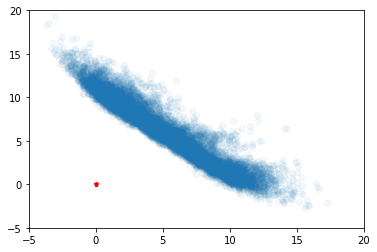

real: 0.0004994000,
mean: 0.0004990606,
 std: 0.0000041152, 
accuracy: 99.932%


In [7]:
def calIntegral(needprint=False):
    if torch.isnan(loss):
        print("Nan!")
        return
    with torch.no_grad():
        x, loggx = flow.sample_and_log_prob(10000)
        s0, s1 = x[:,0], x[:,1]

        intgral = torch.exp(logf(x) - loggx).mean()

        if(needprint):
            plt.scatter(s0, s1, marker='o', alpha=0.05)
            plt.plot(0, 0, 'rp', markersize=5)
            plt.xlim([-5, 20])
            plt.ylim([-5, 20])
            plt.show()
        return intgral

v = [calIntegral(i==0) for i in range(100)]
real = 0.0004994
print("real: %.10f,\nmean: %.10f,\n std: %.10f, \naccuracy: %.3f%%" % (real, np.mean(v),
                                np.std(v), (1-np.abs(np.mean(v) - real)/real)*100))